In [1]:
import torch
from torch import nn, optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torchmetrics

import pandas as pd
from tqdm.notebook import trange, tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split
import gensim.downloader
from sklearn.linear_model import LinearRegression
import swifter

device = 'cpu'

In [2]:
#df = pd.read_json('gutenberg-dataset-v2.json')
df = pd.read_json('dataset.json')
#embedding_vectors = gensim.downloader.load('glove-twitter-25')

#embedding_dim = len(embedding_vectors['test'])
chunk_size = 2000


In [3]:
total_vocabulary = set()
for row in tqdm(df.iterrows(), total=len(df)):
    text = row[1]['text']
    words = text.split()
    for word in words:
        total_vocabulary.add(word)

len(total_vocabulary)

  0%|          | 0/13128 [00:00<?, ?it/s]

3112272

In [4]:
total_frequencies = {word: 0 for word in total_vocabulary}
for row in tqdm(df.iterrows(), total=len(df)):
    text = row[1]['text']
    words = text.split()
    for word in words:
        total_frequencies[word] = total_frequencies[word] + 1


  0%|          | 0/13128 [00:00<?, ?it/s]

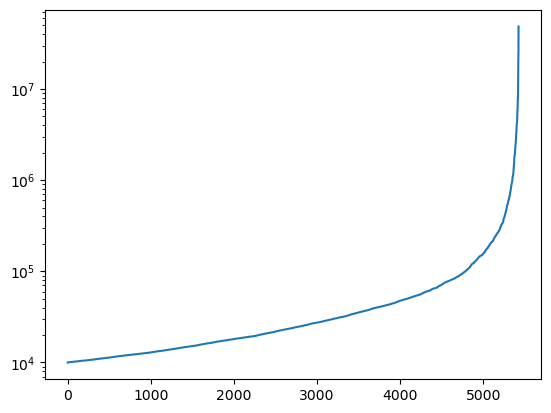

5423


In [5]:
frequency_cutoff = 10000 #300 # 500 #10000

f = [total_frequencies[x] for x in total_frequencies if total_frequencies[x] > frequency_cutoff]
f.sort()

plt.plot(f)
plt.yscale('log')
plt.show()

print(len(f))


In [6]:
select_frequencies = {}
select_vocabulary = []

select_vocabulary_set = set()

for word in tqdm(total_vocabulary):
    f = total_frequencies[word]
    if f > frequency_cutoff: #old: 500
        select_frequencies[word] = f
        select_vocabulary.append(word)
        select_vocabulary_set.add(word)


  0%|          | 0/3112272 [00:00<?, ?it/s]

In [7]:
tqdm.pandas()

def count_word_frequencies(text):
    frequencies = {word: 0 for word in select_vocabulary}
    words = text.split()
    word_count = len(words)
    for word in words:
        if word in select_vocabulary_set:
            frequencies[word] = frequencies[word] + 1

    list = np.zeros(len(select_vocabulary))
    for index, word in enumerate(select_vocabulary):
        freq = frequencies[word] / word_count
        if freq != 0:
            list[index] = -np.log(freq)
        else:
            list[index] = 0

    return list


df['word_frequencies'] = df['text'].progress_apply(count_word_frequencies)

  0%|          | 0/13128 [00:00<?, ?it/s]

In [8]:
for index, word in tqdm(enumerate(select_vocabulary), total=len(select_vocabulary)):
    df['W: ' + word] = df['word_frequencies'].apply(lambda l: l[index])


  0%|          | 0/5423 [00:00<?, ?it/s]

/tmp/ipykernel_15343/27503632.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['W: ' + word] = df['word_frequencies'].apply(lambda l: l[index])
/tmp/ipykernel_15343/27503632.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['W: ' + word] = df['word_frequencies'].apply(lambda l: l[index])
/tmp/ipykernel_15343/27503632.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.conca

In [9]:
#df = (df.drop('title', axis=1).drop('author', axis=1).drop('text_ratio', axis=1).drop('text', axis=1).drop('weights', axis=1).drop('word_frequencies', axis=1).drop('text_len_characters', axis=1))
#df = (df.drop('title', axis=1).drop('author', axis=1).drop('text_ratio', axis=1).drop('text', axis=1).drop('word_frequencies', axis=1))

df = df.copy()

In [10]:
df = (df.drop('title', axis=1).drop('author', axis=1).drop('text_ratio', axis=1).drop('text', axis=1).drop('word_frequencies', axis=1))

In [11]:
df

,date,W: weak,W: command,W: reminded,W: billy,W: carried,W: tied,W: disappeared,W: driver,W: tree,...,W: share,W: desert,W: especially,W: teacher,W: congregation,W: kind,W: affectionate,W: sigh,W: wise,W: realize
0,1904,0.000000,0.000000,0.000000,0.00000,0.000000,8.115521,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1780,8.815073,6.735632,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,8.815073,0.000000,0.000000,7.716461,0.000000,0.000000,8.121926,0.000000
2,1884,0.000000,0.000000,0.000000,0.00000,8.574140,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,7.475528,0.000000,8.574140,8.574140,0.000000
3,1902,9.190469,9.883616,10.576764,0.00000,8.785004,9.883616,9.883616,9.478151,0.000000,...,8.967326,0.000000,10.576764,9.478151,10.576764,8.091857,10.576764,10.576764,0.000000,9.883616
4,1915,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,7.308543,7.308543,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13123,2023,11.708772,10.610160,11.708772,0.00000,8.489896,11.015625,10.322477,11.015625,9.310877,...,10.099334,11.015625,8.713040,7.614427,11.015625,7.837571,0.000000,0.000000,10.610160,9.406187
13124,2023,10.204092,8.258182,0.000000,0.00000,7.761745,9.798627,9.510945,0.000000,10.204092,...,9.798627,6.889906,9.105480,0.000000,0.000000,9.105480,10.897239,0.000000,0.000000,10.897239
13125,2023,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
13126,1916,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,7.855157,0.000000,0.000000,7.855157,0.000000,0.000000,0.000000,0.000000


In [12]:
# df['date'] = (df['date']-df['date'].min())/(df['date'].max()-df['date'].min())

df = (df-df.min())/(df.max()-df.min())

df

,date,W: weak,W: command,W: reminded,W: billy,W: carried,W: tied,W: disappeared,W: driver,W: tree,...,W: share,W: desert,W: especially,W: teacher,W: congregation,W: kind,W: affectionate,W: sigh,W: wise,W: realize
0,0.631579,0.000000,0.000000,0.000000,0.000000,0.000000,0.628242,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.247678,0.682397,0.496500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.687618,0.000000,0.000000,0.628400,0.000000,0.000000,0.598687,0.000000
2,0.569659,0.000000,0.000000,0.000000,0.000000,0.677437,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.608779,0.000000,0.610380,0.632021,0.000000
3,0.625387,0.711457,0.728546,0.752944,0.000000,0.694098,0.765115,0.729109,0.699734,0.000000,...,0.714682,0.000000,0.825038,0.674736,0.737630,0.658971,0.792026,0.752944,0.000000,0.732407
4,0.665635,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.552177,0.570102,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13123,1.000000,0.906405,0.782101,0.833530,0.000000,0.670781,0.852747,0.761484,0.813240,0.688978,...,0.804901,0.832255,0.679659,0.542060,0.768236,0.638263,0.000000,0.000000,0.782101,0.697028
13124,1.000000,0.789924,0.608731,0.000000,0.000000,0.613251,0.758536,0.701618,0.000000,0.755073,...,0.780935,0.520548,0.710271,0.000000,0.000000,0.741517,0.816024,0.000000,0.000000,0.807520
13125,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
13126,0.668731,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.612740,0.000000,0.000000,0.639695,0.000000,0.000000,0.000000,0.000000


In [13]:
X = df.iloc[:, 1:]
y = df['date']

X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2, random_state=42, shuffle=True)

In [14]:
#train_dataloader = DataLoader((torch.from_numpy(X_train), torch.from_numpy(y_train)), batch_size=16)
#test_dataloader = DataLoader((torch.from_numpy(X_test), torch.from_numpy(y_test)), batch_size=16)

In [15]:
# Define the linear regression model



class LinearRegressionModel(nn.Module):
    def __init__(self, input_size):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_size, 1)
        # self.activation = nn.Sigmoid()
        # self.linear2 = nn.Linear(1000, 1000)
        # self.activation2 = nn.ReLU()
        # self.linear3 = nn.Linear(1000, 100)
        # self.activation3 = nn.ReLU()
        # self.linear4 = nn.Linear(1000, 1)
        #self.activation4 = nn.Sigmoid()

    def forward(self, x):
        x = self.linear(x)
        # x = self.activation(x)
        # x = self.linear2(x)
        # x = self.activation2(x)
        # x = self.linear3(x)
        # x = self.activation3(x)
        # x = self.linear4(x)
        # x = self.activation4(x)

        return x

In [16]:
df.isnull().values.any()


False

In [24]:
# Initialize the model, loss function, and optimizer

num_epochs = 200
loading_steps = 10
loading_count = 0

learning_rate = 0.001

input_size = X_train.shape[1]
model = LinearRegressionModel(input_size)
model.to(device)

criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.FloatTensor(y_train).to(device).view(-1, 1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

train_loader = DataLoader(train_dataset, batch_size=len(X_train_tensor) // 1, shuffle=True)

losses = []


model.train()

for epoch in tqdm(range(num_epochs)):

    for inputs, labels in (train_loader):
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        losses.append(loss.item())

        loss.backward()

        # https://stackoverflow.com/questions/66648432/pytorch-test-loss-becoming-nan-after-some-iteration
        #torch.nn.utils.clip_grad_norm_(model.parameters(), 5)

        optimizer.step()

    if epoch % (num_epochs / loading_steps) == 0:
        print(f'{loading_count}0% done')
        print(f'Loss: {loss}')
        loading_count = loading_count + 1

print('finished')


  0%|          | 0/200 [00:00<?, ?it/s]

00% done
Loss: 0.5085122585296631
10% done
Loss: 0.2750261425971985
20% done
Loss: 0.15531843900680542
30% done
Loss: 0.1379368156194687
40% done
Loss: 0.1248529851436615
50% done
Loss: 0.11392781138420105
60% done
Loss: 0.11063426733016968
70% done
Loss: 0.11209823191165924
80% done
Loss: 0.1072276309132576
90% done
Loss: 0.10213150829076767
finished


In [30]:
model.train()
loading_count = 0

for epoch in tqdm(range(200)):

    for inputs, labels in (train_loader):
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        losses.append(loss.item())

        loss.backward()

        # https://stackoverflow.com/questions/66648432/pytorch-test-loss-becoming-nan-after-some-iteration
        #torch.nn.utils.clip_grad_norm_(model.parameters(), 5)

        optimizer.step()

    if epoch % (num_epochs / loading_steps) == 0:
        print(f'{loading_count}0% done')
        print(f'Loss: {loss}')
        loading_count = loading_count + 1


  0%|          | 0/200 [00:00<?, ?it/s]

00% done
Loss: 0.12195805460214615
10% done
Loss: 0.1238982081413269
20% done
Loss: 0.11724762618541718
30% done
Loss: 0.11938747018575668
40% done
Loss: 0.11273752152919769
50% done
Loss: 0.12238818407058716
60% done
Loss: 0.10445999354124069
70% done
Loss: 0.1318635493516922
80% done
Loss: 0.09909704327583313
90% done
Loss: 0.1283930540084839


Mean Squared Error: 0.02877984228353871


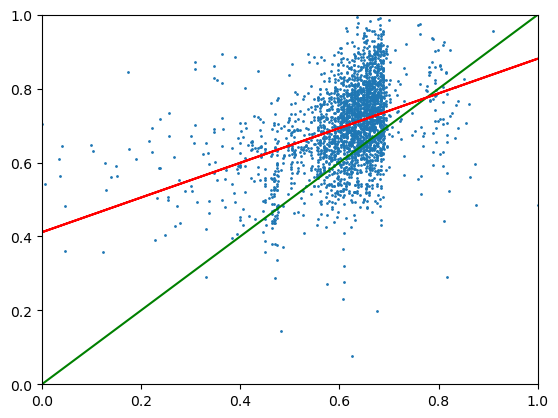

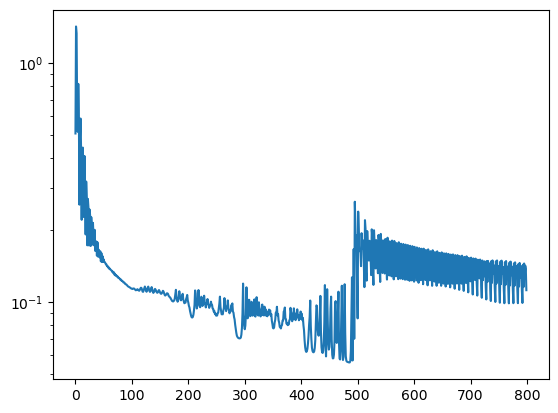

In [31]:
model.eval()


with torch.no_grad():
    X_test_tensor = torch.FloatTensor(X_test).to(device)
    y_pred = model(X_test_tensor).detach().numpy()

    # Calculate the mean squared error to evaluate the model
    mse = ((y_test - y_pred) ** 2).mean()
    print(f"Mean Squared Error: {mse}")

    # plt.hist(y_pred, bins=100)
    # plt.show()

    # plt.hist(y_test, bins=100)
    # plt.show()


    plt.scatter(y_test, y_pred, s=1)

    plt.axline([0, 0], [1, 1], color='green')

    m, b = np.polyfit(y_test, y_pred, 1)
    plt.plot(y_test, m * y_test + b, color='red')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.show()

    plt.plot(losses)
    plt.yscale('log')
    #plt.ylim(0, 0.01)
    plt.show()





# coeff_list = []
# name_list = []
# # View the coefficients
# with torch.no_grad():
#     coefficients = model.linear.weight.view(-1).numpy()

#     for i, coef in enumerate(coefficients):
#         coeff_list.append(coef)
#         name_list.append(X.columns[i])

# coef_df = pd.DataFrame(data={'names': name_list, 'coefficients': coeff_list}).sort_values('coefficients', ascending=False)

# coef_df